In [1]:
ls

model/  Train.ipynb


------------------------------------ epoch 001 (0 steps) ------------------------------------
Max loss: 1.0087573528289795
Min loss: 1.0018398761749268
Mean loss: 1.00500883658727
Std loss: 0.0025105518383904154
Total Loss: 6.030053019523621
saved model at ./weights/model_001.pth
------------------------------------ epoch 002 (6 steps) ------------------------------------
Max loss: 1.0038663148880005
Min loss: 0.9962489008903503
Mean loss: 1.0012801984945934
Std loss: 0.0025586870554932853
Total Loss: 6.00768119096756
------------------------------------ epoch 003 (12 steps) ------------------------------------
Max loss: 1.0057692527770996
Min loss: 0.999032199382782
Mean loss: 1.0021658837795258
Std loss: 0.0023014581623905465
Total Loss: 6.0129953026771545
------------------------------------ epoch 004 (18 steps) ------------------------------------
Max loss: 1.0050029754638672
Min loss: 0.9959608316421509
Mean loss: 1.001015881697337
Std loss: 0.0036870280404473947
Total Loss: 6.006

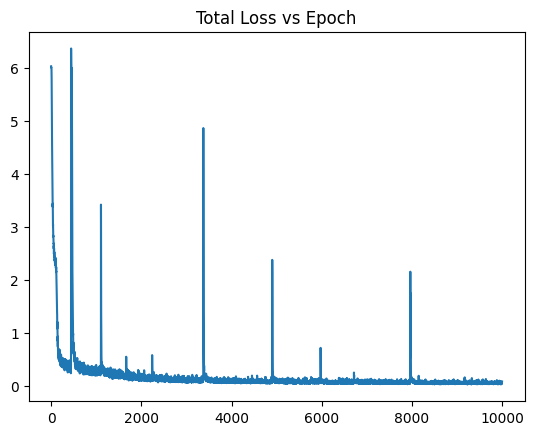

In [6]:
from model.unet import Unet
from model.training import *
from model.diffusionModel import DiffusionModel
from torch.utils.data import DataLoader
from torch.optim import Adam
from model.t5 import t5_encode_text
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
import numpy as np

log_file='training_progress.txt'
def show_msg(msg, file=log_file):
    if file is not None:
        with open(file, 'a') as f:
            f.write(msg+"\n")
    print(msg)

# training hyperparameters
batch_size = 16
n_epoch = 10000
learning_rate = 1e-3
# network hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
n_feat = 512 # hidden dimension feature
max_text_len = 128 # word vector max size
height = 64 # 64x64 image
save_dir = './weights/'
# diffusion hyperparameters
timesteps = 5000

dataset_data_path = './dataset_conceptual_captions_lite.npy'
# load dataset
dataset = CustomDataset(dataset_data_path)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1, drop_last=True)

df = DiffusionModel(timesteps, height)
model = Unet(in_channels=3, n_feat=n_feat, max_text_len=max_text_len, height=height, device=device).to(device)
#model.load_state_dict(torch.load(save_dir+"model_901.pth", map_location=device))
optimizer = Adam(model.parameters(), lr=learning_rate)
open(log_file, 'w').close()
list_total_loss = []
training_steps = 0
model.train()
for epoch in range(n_epoch):
    show_msg("------------------------------------ epoch {:03d} ({} steps) ------------------------------------".format(epoch + 1, training_steps))
    total_loss = 0
    loss_list = []
    # linearly decay of learning rate
    #optimizer.param_groups[0]['lr'] = learning_rate*(1-(epoch/n_epoch))
    for x_0, labels in dataloader:   # x_0: images
        optimizer.zero_grad()
        x_0 = x_0.to(device)
        # perturb data
        noise = torch.randn_like(x_0).to(device)
        t = torch.randint(1, timesteps + 1, (x_0.shape[0],)).to(device)
        x_t = df.noise_image(x_0, t, noise).to(device)
        t_emb, t_mask = t5_encode_text(labels)
        # use network to recover noise
        pred_noise = model(x_t, t/timesteps, t_emb=t_emb, t_mask=t_mask)

        # loss is measures the element-wise mean squared error between the predicted and true noise
        loss = F.mse_loss(pred_noise, noise)
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
        training_steps+=1
        #if (training_steps%100) == 0:
            #print("Total train step: {}, Loss: {}".format(training_steps,loss))
            
    loss_list = np.array(loss_list)
    show_msg("Max loss: {}".format(loss_list.max()))
    show_msg("Min loss: {}".format(loss_list.min()))
    total_loss = loss_list.sum()
    show_msg("Mean loss: {}".format(loss_list.mean()))
    show_msg("Std loss: {}".format(loss_list.std()))
    show_msg("Total Loss: {}".format(total_loss))
    list_total_loss.append(total_loss)
  # save model periodically
    if epoch%100==0 or epoch == int(n_epoch-1):
        torch.save(model.state_dict(), save_dir + "model_{:03d}.pth".format(epoch+1))
        show_msg('saved model at ' + save_dir + "model_{:03d}.pth".format(epoch+1))
    
plt.figure()
plt.plot(list_total_loss)
plt.title("Total Loss vs Epoch")
plt.savefig('train.png')

show_msg("Fin del entrenamiento")

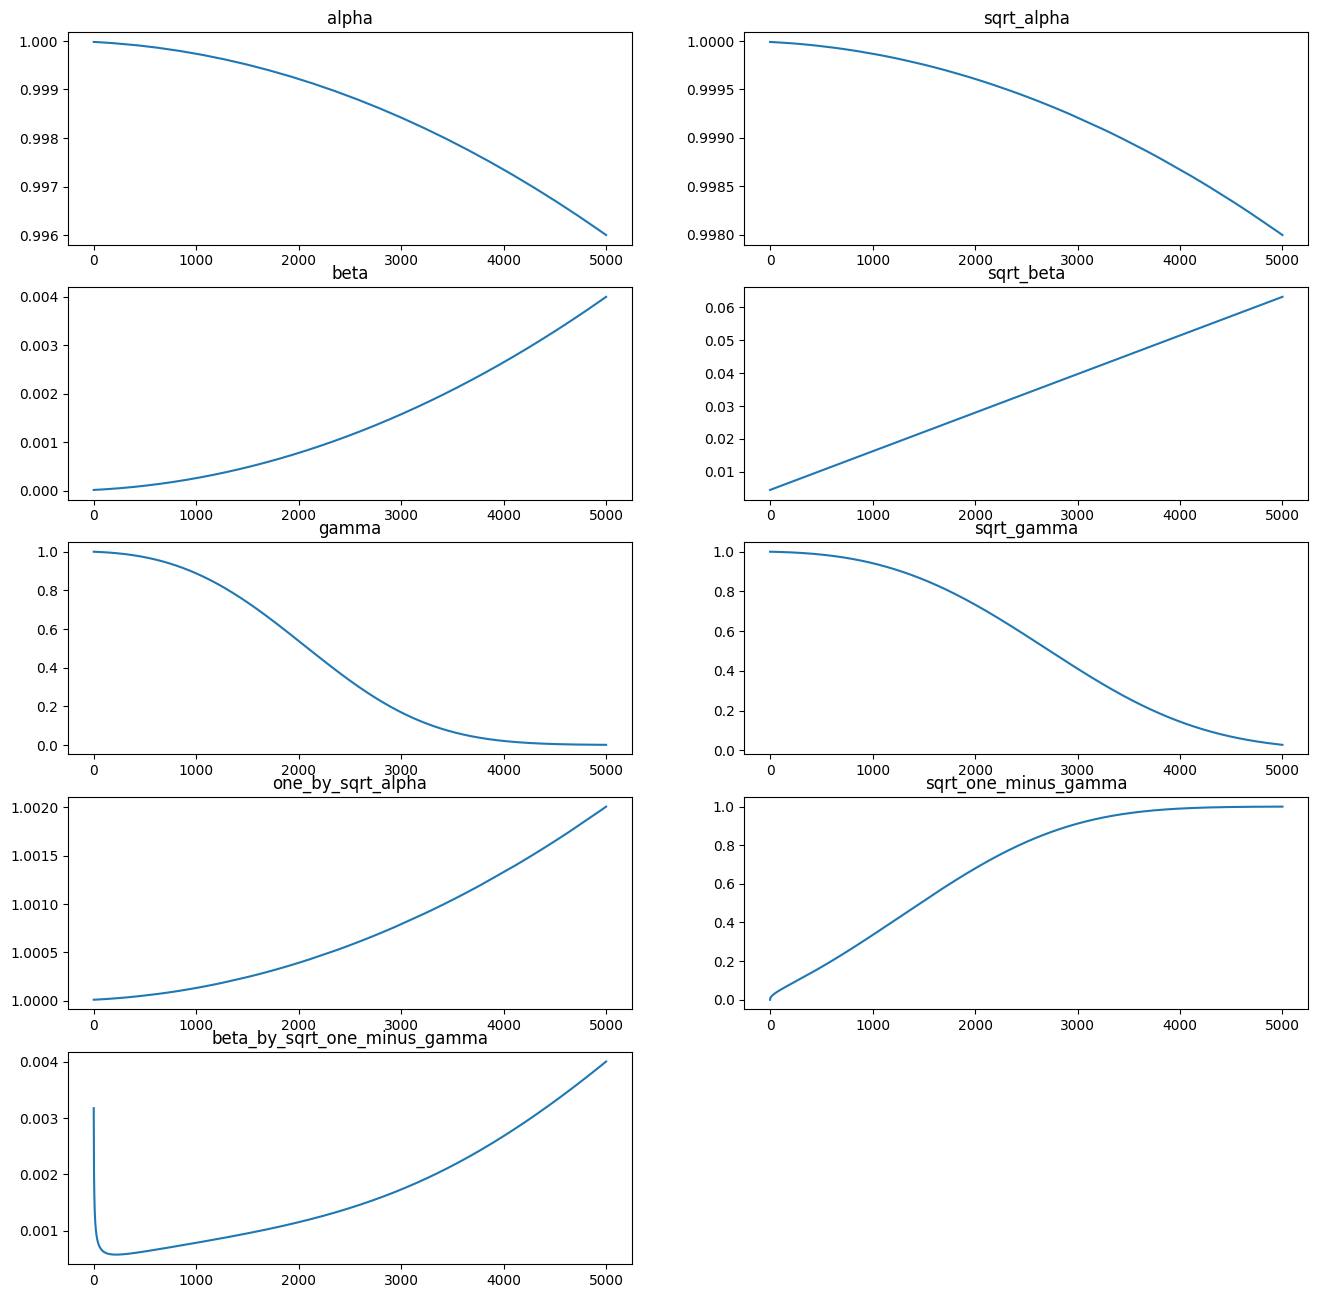

In [3]:
import numpy as np
import torch
from datetime import datetime
from torchvision import transforms
import matplotlib.pyplot as plt
from model.t5 import t5_encode_text

class DiffusionModel():
  # return beta_sqrt, alpha, alpha_sqrt, gamma, gamma_sqrt for noise and denoise image
  def __init__(self, timesteps, height, beta1=0.0001, beta2=0.02):
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
    scale = 1000 / timesteps
    beta1 = scale * beta1
    beta2 = scale * beta2
    beta = torch.linspace(beta1**0.5, beta2**0.5, timesteps + 1, device=self.device)**2
    alpha = 1 - beta
    one_by_sqrt_alpha = 1./alpha.sqrt()
    gamma = torch.cumprod(alpha, axis=0)
    gamma[0] = 1
    sqrt_one_minus_gamma = (1. - gamma).sqrt()
    beta_by_sqrt_one_minus_gamma = beta/sqrt_one_minus_gamma
    self.noise_schedule_dict = {'alpha':alpha, 'sqrt_alpha':alpha.sqrt(),
                   'beta':beta, 'sqrt_beta':beta.sqrt(),
                   'gamma':gamma, 'sqrt_gamma':gamma.sqrt(),
                   'one_by_sqrt_alpha':one_by_sqrt_alpha,
                   'sqrt_one_minus_gamma':sqrt_one_minus_gamma,
                   'beta_by_sqrt_one_minus_gamma':beta_by_sqrt_one_minus_gamma}
    self.timesteps = timesteps
    self.height = height

  def show_noise_schedule(self):
    rows = 5
    cols = 2
    plt.figure(figsize=(16,16))
    for i, schedule in enumerate(self.noise_schedule_dict):
      plt.subplot(rows, cols, i + 1)
      plt.title(schedule)
      curr_schedule = self.noise_schedule_dict[schedule]
      plt.plot(curr_schedule.to('cpu'))
        
df = DiffusionModel(5000,128)
df.show_noise_schedule()

108


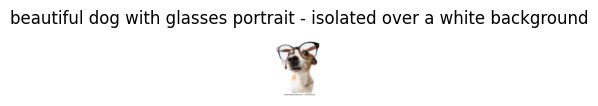

In [7]:
import torch
import matplotlib.pyplot as plt
from model.training import CustomDataset
from model.diffusionModel import DiffusionModel

dataset_name = './dataset_conceptual_captions_lite.npy'
dataset = CustomDataset(dataset_name)

label = 'beautiful dog with glasses portrait - isolated over a white background'

rows = len(dataset)
print(rows)
plt.figure(figsize=(16,rows))
for i in range(len(dataset)):
    img, curr_label = dataset[i]
    if curr_label == label:
        plt.subplot(rows, 1, i+1)
        plt.axis('off')
        plt.title(curr_label)
        plt.imshow(img.permute(1,2,0))